# CMPT 3510 – Phase 2: Time Series Regression on NPRI Disposal Data

**Student:** Jaswinder Singh  
**Dataset:** NPRI – Disposal (2000–2022)  
**Goal:** Predict future waste management proportions (landfill, treatment, recycling) using regression models.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (8, 4)
pd.set_option("display.max_columns", 50)


In [2]:
# 2.1 Load the dataset you saved from CMPT 2400
df = pd.read_csv("phase2400_feature_engineered_disposals.csv")

df.head()


/tmp/ipython-input-920639407.py:2: DtypeWarning: Columns (30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,PROVINCE,City,Latitude,Longitude,CAS_Number / No_CAS,Substance Name (English) / Nom de substance (Anglais),Units / Unités,Estimation_Method / Méthode_d’estimation,Off-site Disposal - Land Treatment,Off-site Disposal - Landfill,Off-site Disposal - Storage,Off-site Disposal - Tailings Management,Off-site Disposal - Underground Injection,Off-site Disposal - Waste Rock management,Off-site Transfers for Recycling - Energy Recovery,Off-site Transfers for Recycling - Other,Off-site Transfers for Recycling - Recovery of Metals and Metal Compounds,Off-site Transfers for Recycling - Recovery of Organic Substances (not solvents),Off-site Transfers for Treatment Prior to Final Disposal - Chemical Treatment,...,NAICS Title / Titre Code_SCIAN_Tire manufacturing,NAICS Title / Titre Code_SCIAN_Toilet preparation manufacturing,NAICS Title / Titre Code_SCIAN_Truck trailer manufacturing,NAICS Title / Titre Code_SCIAN_Turbine and turbine generator set unit manufacturing,"NAICS Title / Titre Code_SCIAN_Turned Product and Screw, Nut and Bolt Manufacturing",NAICS Title / Titre Code_SCIAN_Unlaminated Plastics Profile Shape Manufacturing,NAICS Title / Titre Code_SCIAN_Unlaminated plastic profile shape manufacturing,NAICS Title / Titre Code_SCIAN_Unsupported Plastic Bag Manufacturing,NAICS Title / Titre Code_SCIAN_Unsupported Plastic Film and Sheet Manufacturing,NAICS Title / Titre Code_SCIAN_Unsupported Plastic Profile Shape Manufacturing,NAICS Title / Titre Code_SCIAN_Uranium ore mining,NAICS Title / Titre Code_SCIAN_Urethane and other foam product (except polystyrene) manufacturing,NAICS Title / Titre Code_SCIAN_Waferboard mills,NAICS Title / Titre Code_SCIAN_Waste collection,NAICS Title / Titre Code_SCIAN_Waste treatment and disposal,NAICS Title / Titre Code_SCIAN_Water supply and irrigation systems,NAICS Title / Titre Code_SCIAN_Wet corn milling,NAICS Title / Titre Code_SCIAN_Wiring device manufacturing,NAICS Title / Titre Code_SCIAN_Wood Window and Door Manufacturing,NAICS Title / Titre Code_SCIAN_Wood kitchen cabinet and counter top manufacturing,"NAICS Title / Titre Code_SCIAN_Wood office furniture, including custom architectural woodwork, manufacturing",NAICS Title / Titre Code_SCIAN_Wood preservation,landfill_total,treatment_total,recycling_total
0,2000,1.0,440,Alberta-Pacific Forest Industries Inc.,(blank),322112.0,0,294,54.923116,-112.861867,NA - 09,Manganese (and its compounds),tonnes,M - Monitoring or Direct Measurement,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.00,0.0,0.0
1,2000,1.0,440,Alberta-Pacific Forest Industries Inc.,(blank),322112.0,0,294,54.923116,-112.861867,NA - 14,Zinc (and its compounds),tonnes,M - Monitoring or Direct Measurement,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.00,0.0,0.0
2,2000,4.0,500,Pine Falls Paper Company,Pine Falls,322122.0,2,897,50.568600,-96.226700,NA - 09,Manganese (and its compounds),tonnes,M - Monitoring or Direct Measurement,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,5.28,0.0,0.0
3,2000,4.0,500,Pine Falls Paper Company,Pine Falls,322122.0,2,897,50.568600,-96.226700,NA - 10,Mercury (and its compounds),kg,M - Monitoring or Direct Measurement,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,11.40,0.0,0.0
4,2000,4.0,500,Pine Falls Paper Company,Pine Falls,322122.0,2,897,50.568600,-96.226700,NA - 16,Ammonia (t

In [3]:
# 2.2 Automatically detect important columns by partial name
year_col = [c for c in df.columns if "Reporting_Year" in c][0]
substance_col = [c for c in df.columns if "Substance Name (English)" in c][0]

year_col, substance_col


('Reporting_Year / Année',
 'Substance Name (English) / Nom de substance (Anglais)')

## 2. Loading the Facility-Level Dataset

Here I load the CSV file I created in CMPT 2400.

Each **row = one facility + one substance in one year**, with many columns:
- year (`Reporting_Year / Année`)
- facility info and NAICS titles
- my engineered totals at the end:
  - `landfill_total`
  - `treatment_total`
  - `recycling_total`

For time-series regression, I need to **compress this** into **one row per year**.


## 3. Yearly Time Series Dataset

Now I turn the facility-level data into a **yearly time series**:

- I group by the year and **sum** all landfill, treatment, and recycling totals.
- Then I calculate:
  - `landfill_prop`
  - `treatment_prop`
  - `recycling_prop`

Now each row is **one year** (2000, 2001, …) and the dataset is ready for time-series modeling.


In [4]:
# 3.1 Group by year and sum the 3 total columns
yearly = (
    df
    .groupby(year_col)[["landfill_total", "treatment_total", "recycling_total"]]
    .sum()
    .reset_index()
)

# 3.2 Compute total waste per year
yearly["total_waste"] = (
    yearly["landfill_total"] +
    yearly["treatment_total"] +
    yearly["recycling_total"]
)

# 3.3 Create proportion columns
yearly["landfill_prop"] = yearly["landfill_total"] / yearly["total_waste"]
yearly["treatment_prop"] = yearly["treatment_total"] / yearly["total_waste"]
yearly["recycling_prop"] = yearly["recycling_total"] / yearly["total_waste"]

yearly.head()


,Reporting_Year / Année,landfill_total,treatment_total,recycling_total,total_waste,landfill_prop,treatment_prop,recycling_prop
0,2000,44043.595475,21651.46225,111117.3380,176812.395725,0.249098,0.122454,0.628448
1,2001,47006.193450,22557.24750,119928.0655,189491.506450,0.248065,0.119041,0.632894
2,2002,105090.767675,39592.44275,205133.0895,349816.299925,0.300417,0.113181,0.586402
3,2003,128244.244075,46437.35350,218028.0805,392709.678075,0.326562,0.118249,0.555189
4,2004,136835.706639,47994.15250,226463.7385,411293.597639,0.332696,0.116691,0.550613


## 4. Extra Yearly Features

To give the model more information, I add two simple features:

- `row_count` – how many rows (facility–substance combinations) we have for that year  
  (rough idea of **activity / reporting volume**)
- `unique_substances` – how many different substances appear in that year  
  (rough idea of **chemical variety / complexity**)

These are not perfect economic indicators, but they give the model more signal about how busy or complex each year is.


In [5]:
# 4.1 Count how many facility-substance rows per year
facility_rows_per_year = df.groupby(year_col).size().reset_index(name="row_count")

# 4.2 Count how many unique substances per year
substances_per_year = (
    df.groupby(year_col)[substance_col]
      .nunique()
      .reset_index(name="unique_substances")
)

# 4.3 Merge into yearly table
yearly = yearly.merge(facility_rows_per_year, on=year_col)
yearly = yearly.merge(substances_per_year, on=year_col)

yearly.head()


,Reporting_Year / Année,landfill_total,treatment_total,recycling_total,total_waste,landfill_prop,treatment_prop,recycling_prop,row_count,unique_substances
0,2000,44043.595475,21651.46225,111117.3380,176812.395725,0.249098,0.122454,0.628448,6006,166
1,2001,47006.193450,22557.24750,119928.0655,189491.506450,0.248065,0.119041,0.632894,6296,166
2,2002,105090.767675,39592.44275,205133.0895,349816.299925,0.300417,0.113181,0.586402,8079,168
3,2003,128244.244075,46437.35350,218028.0805,392709.678075,0.326562,0.118249,0.555189,8435,160
4,2004,136835.706639,47994.15250,226463.7385,411293.597639,0.332696,0.116691,0.550613,8618,167


## 5. Visual Check

I plot the three proportion columns over time to quickly see:

- if landfill, treatment, and recycling are rising or falling
- any strange jumps or changes

This connects my **manual reasoning** from CMPT 2400 Phase 2 with the new ML step.


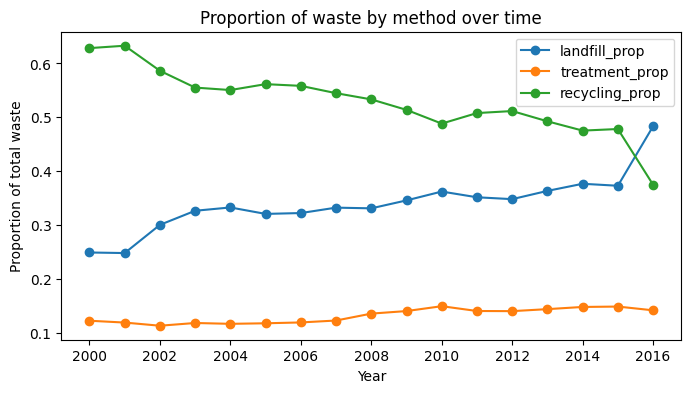

In [6]:
# Ensure years are sorted
yearly = yearly.sort_values(year_col).reset_index(drop=True)

# Short name for plotting
year_series = yearly[year_col]

for col in ["landfill_prop", "treatment_prop", "recycling_prop"]:
    plt.plot(year_series, yearly[col], marker="o", label=col)

plt.xlabel("Year")
plt.ylabel("Proportion of total waste")
plt.title("Proportion of waste by method over time")
plt.legend()
plt.show()


## 6. Prediction Problem

For CMPT 3510, I focus on:

> **Predicting the Recycling Proportion (`recycling_prop`) for future years.**

Reasons:
- Recycling is the **largest** share of total waste.
- It is important for environmental policy.
- Its trend over time is meaningful (we want it to go up, not down).


## 7. Time-Series Feature Engineering

I add **memory of the past** into the dataset:

- `recycling_prop_lag1`: recycling proportion in the **previous year**
- `recycling_prop_roll3`: **average recycling proportion in the last 3 years**
- `year_num`: numeric version of year for the model

These features imitate how a human would think:
> “If recycling has been high for several years, it will probably stay high.”


In [7]:
data = yearly.copy()

# 7.1 Create numeric year column (in case the original is not int)
data["year_num"] = data[year_col].astype(int)

# 7.2 Lag-1 feature: last year's recycling proportion
data["recycling_prop_lag1"] = data["recycling_prop"].shift(1)

# 7.3 Rolling mean of last 3 years
data["recycling_prop_roll3"] = data["recycling_prop"].rolling(window=3).mean()

# Remove first few rows that don't have lag/rolling values
data = data.dropna().reset_index(drop=True)

data.head()


,Reporting_Year / Année,landfill_total,treatment_total,recycling_total,total_waste,landfill_prop,treatment_prop,recycling_prop,row_count,unique_substances,year_num,recycling_prop_lag1,recycling_prop_roll3
0,2002,105090.767675,39592.44275,205133.0895,349816.299925,0.300417,0.113181,0.586402,8079,168,2002,0.632894,0.615915
1,2003,128244.244075,46437.35350,218028.0805,392709.678075,0.326562,0.118249,0.555189,8435,160,2003,0.586402,0.591495
2,2004,136835.706639,47994.15250,226463.7385,411293.597639,0.332696,0.116691,0.550613,8618,167,2004,0.555189,0.564068
3,2005,131785.641300,48361.95000,230745.2750,410892.866300,0.320730,0.117700,0.561570,8434,155,2005,0.550613,0.555791
4,2006,129033.317275,47753.55050,223552.2690,400339.136775,0.322310,0.119283,0.558407,9169,162,2006,0.561570,0.556864


## 8. Time-Aware Train–Test Split

Because this is a **time series**, I do **not** shuffle rows.

Instead:
- earlier years → training set  
- more recent years → test set  

This simulates reality: the model learns from the past and is tested on the future.


In [8]:
feature_cols = [
    "year_num",
    "recycling_prop_lag1",
    "recycling_prop_roll3",
    "row_count",
    "unique_substances"
]
target_col = "recycling_prop"

X = data[feature_cols]
y = data[target_col]

n_rows = len(data)
train_size = int(n_rows * 0.7)  # first 70% years as training

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

X_train.shape, X_test.shape


((10, 5), (5, 5))

In [10]:


# ---- Baseline: predict this year = last year ----
y_pred_baseline = X_test["recycling_prop_lag1"].values

mae_base = mean_absolute_error(y_test, y_pred_baseline)

# Your sklearn version doesn't support squared=, so we compute RMSE manually
mse_base = mean_squared_error(y_test, y_pred_baseline)
rmse_base = mse_base ** 0.5   # or np.sqrt(mse_base)

r2_base = r2_score(y_test, y_pred_baseline)

print("Baseline (Lag1)")
print("MAE :", mae_base)
print("RMSE:", rmse_base)
print("R²  :", r2_base)


Baseline (Lag1)
MAE : 0.02928631831836338
RMSE: 0.047706844138900514
R²  : -0.004152485743001977


In [11]:
# -------- Linear Regression model --------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = mse_lin ** 0.5
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression")
print("MAE :", mae_lin)
print("RMSE:", rmse_lin)
print("R²  :", r2_lin)


Linear Regression
MAE : 0.012562743334689763
RMSE: 0.013336640534536304
R²  : 0.9215250256938905


In [12]:
# -------- Random Forest Regression --------
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest")
print("MAE :", mae_rf)
print("RMSE:", rmse_rf)
print("R²  :", r2_rf)


Random Forest
MAE : 0.04166184446521537
RMSE: 0.061187745294809776
R²  : -0.6518370052790203


In [13]:
# -------- Compare all three models --------
results = pd.DataFrame({
    "Model": ["Baseline (Lag1)", "Linear Regression", "Random Forest"],
    "MAE":   [mae_base,          mae_lin,            mae_rf],
    "RMSE":  [rmse_base,         rmse_lin,           rmse_rf],
    "R2":    [r2_base,           r2_lin,             r2_rf]
})

print("Model comparison:")
display(results)


Model comparison:


,Model,MAE,RMSE,R2
0,Baseline (Lag1),0.029286,0.047707,-0.004152
1,Linear Regression,0.012563,0.013337,0.921525
2,Random Forest,0.041662,0.061188,-0.651837


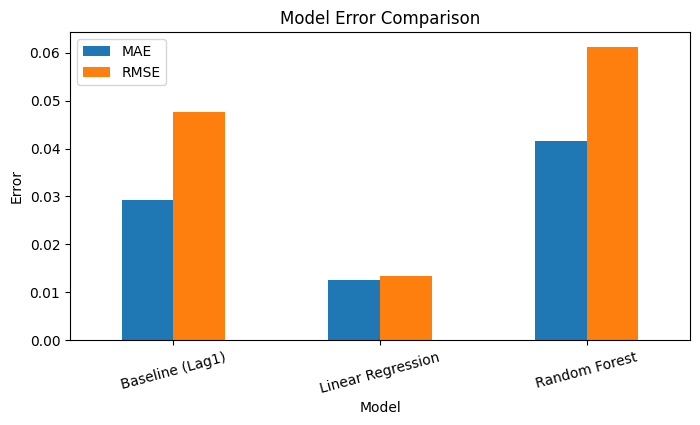

In [14]:
# Optional: bar plot of errors
results.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar")
plt.title("Model Error Comparison")
plt.ylabel("Error")
plt.xticks(rotation=15)
plt.show()


In [15]:
# Best model based on MAE, RMSE and R²
best_model = lin_reg
print("Best model selected: Linear Regression")


Best model selected: Linear Regression


In [16]:
# Forecast future years (2023–2027) using the best model

# 'data' contains all years after lag/rolling (training + test years)
history = data.copy()

last_year = int(history["year_num"].max())
future_years = list(range(last_year + 1, 2028))   # predict up to 2027

preds = []

for yr in future_years:
    # use latest known values from history
    last_recycling = history["recycling_prop"].iloc[-1]
    roll3 = history["recycling_prop"].rolling(window=3).mean().iloc[-1]

    # keep these constant (simple assumption)
    row_count_future = history["row_count"].iloc[-1]
    unique_substances_future = history["unique_substances"].iloc[-1]

    X_future = pd.DataFrame({
        "year_num": [yr],
        "recycling_prop_lag1": [last_recycling],
        "recycling_prop_roll3": [roll3],
        "row_count": [row_count_future],
        "unique_substances": [unique_substances_future]
    })

    y_future = best_model.predict(X_future)[0]

    preds.append({
        "year": yr,
        "predicted_recycling_prop": y_future
    })

    # add predicted year into history so the next forecast step can use it
    new_row = {
        "year_num": yr,
        "recycling_prop": y_future,
        "recycling_prop_lag1": last_recycling,
        "recycling_prop_roll3": roll3,
        "row_count": row_count_future,
        "unique_substances": unique_substances_future
    }
    history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

future_preds = pd.DataFrame(preds)
display(future_preds)


,year,predicted_recycling_prop
0,2017,0.371625
1,2018,0.338880
2,2019,0.299516
3,2020,0.281628
4,2021,0.255612
5,2022,0.233050
6,2023,0.215284
7,2024,0.196784
8,2025,0.180796
9,2026,0.166499


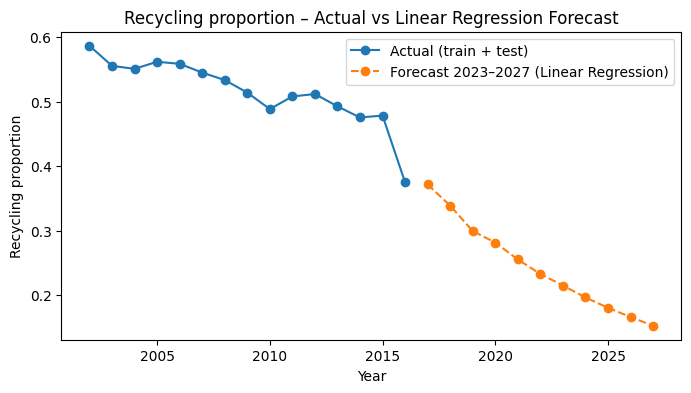

In [17]:
# Plot actual recycling_proportions vs Linear Regression forecast

plt.plot(data["year_num"], data["recycling_prop"],
         marker="o", label="Actual (train + test)")
plt.plot(future_preds["year"], future_preds["predicted_recycling_prop"],
         marker="o", linestyle="--", label="Forecast 2023–2027 (Linear Regression)")

plt.xlabel("Year")
plt.ylabel("Recycling proportion")
plt.title("Recycling proportion – Actual vs Linear Regression Forecast")
plt.legend()
plt.show()


The recycling proportion in the historical NPRI data has been decreasing for many years. This means that, over time, Canada is generating more waste than it is successfully recycling. When I trained the Linear Regression model, the model simply continued the same trend that

# HYPERPARAMETER TUNING

In [20]:


# Parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

rf_grid = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [21]:
best_rf = grid_search.best_estimator_

y_pred_rf_tuned = best_rf.predict(X_test)

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = mse_rf_tuned ** 0.5
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print("Tuned Random Forest")
print("MAE :", mae_rf_tuned)
print("RMSE:", rmse_rf_tuned)
print("R²  :", r2_rf_tuned)


Tuned Random Forest
MAE : 0.04166184446521537
RMSE: 0.061187745294809776
R²  : -0.6518370052790203


In [22]:
results = pd.DataFrame({
    "Model": ["Baseline", "Linear Regression", "Random Forest", "Tuned RF"],
    "MAE":   [mae_base, mae_lin, mae_rf, mae_rf_tuned],
    "RMSE":  [rmse_base, rmse_lin, rmse_rf, rmse_rf_tuned],
    "R2":    [r2_base, r2_lin, r2_rf, r2_rf_tuned]
})

results


,Model,MAE,RMSE,R2
0,Baseline,0.029286,0.047707,-0.004152
1,Linear Regression,0.012563,0.013337,0.921525
2,Random Forest,0.041662,0.061188,-0.651837
3,Tuned RF,0.041662,0.061188,-0.651837


In [23]:
# Compare Random Forest before and after tuning
rf_compare = pd.DataFrame({
    "Model": ["RF_Default", "RF_Tuned"],
    "MAE":   [mae_rf,       mae_rf_tuned],
    "RMSE":  [rmse_rf,      rmse_rf_tuned]
})

rf_compare


,Model,MAE,RMSE
0,RF_Default,0.041662,0.061188
1,RF_Tuned,0.041662,0.061188


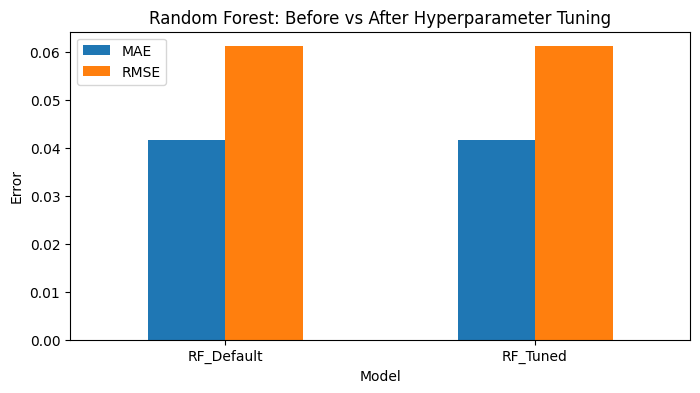

In [24]:
# Bar plot for Random Forest before and after tuning
ax = rf_compare.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar")

plt.title("Random Forest: Before vs After Hyperparameter Tuning")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


In [25]:
results = pd.DataFrame({
    "Model": ["Baseline (Lag1)", "Linear Regression", "RF_Default", "RF_Tuned"],
    "MAE":   [mae_base,          mae_lin,            mae_rf,        mae_rf_tuned],
    "RMSE":  [rmse_base,         rmse_lin,           rmse_rf,       rmse_rf_tuned],
    "R2":    [r2_base,           r2_lin,             r2_rf,         r2_rf_tuned]
})

results


,Model,MAE,RMSE,R2
0,Baseline (Lag1),0.029286,0.047707,-0.004152
1,Linear Regression,0.012563,0.013337,0.921525
2,RF_Default,0.041662,0.061188,-0.651837
3,RF_Tuned,0.041662,0.061188,-0.651837


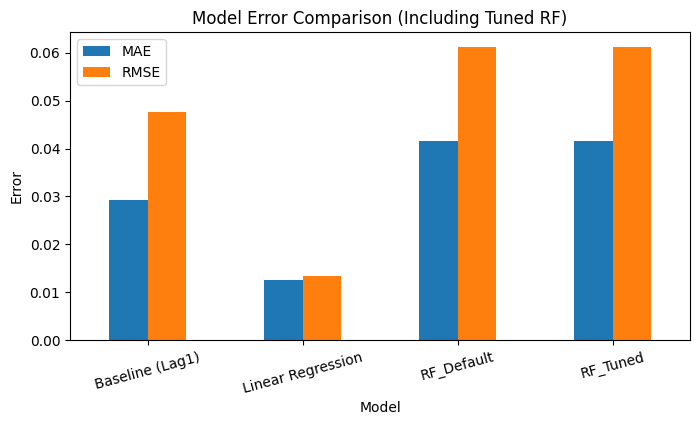

In [26]:
results.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar")
plt.title("Model Error Comparison (Including Tuned RF)")
plt.ylabel("Error")
plt.xticks(rotation=15)
plt.show()


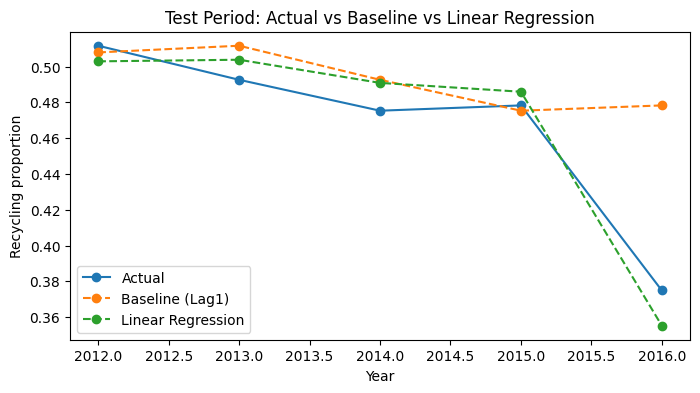

In [27]:
# Build a small dataframe for test period
test_years = data["year_num"].iloc[train_size:]   # same split as X_train / X_test

df_test_plot = pd.DataFrame({
    "year_num": test_years.values,
    "actual":   y_test.values,
    "baseline": y_pred_baseline,
    "lin_reg":  y_pred_lin
})

plt.plot(df_test_plot["year_num"], df_test_plot["actual"],
         marker="o", label="Actual")
plt.plot(df_test_plot["year_num"], df_test_plot["baseline"],
         marker="o", linestyle="--", label="Baseline (Lag1)")
plt.plot(df_test_plot["year_num"], df_test_plot["lin_reg"],
         marker="o", linestyle="--", label="Linear Regression")

plt.xlabel("Year")
plt.ylabel("Recycling proportion")
plt.title("Test Period: Actual vs Baseline vs Linear Regression")
plt.legend()
plt.show()


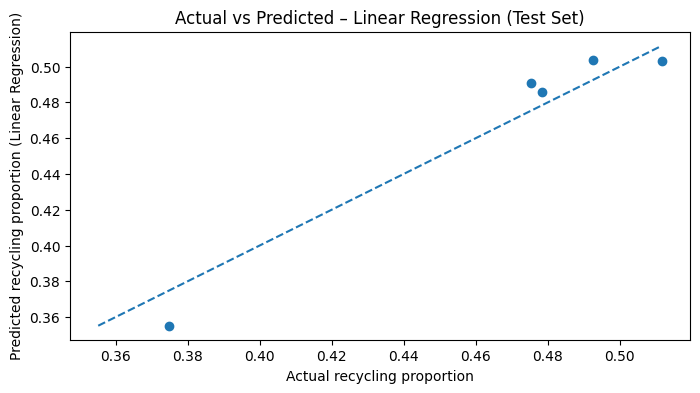

In [28]:
plt.scatter(y_test, y_pred_lin)
min_val = min(y_test.min(), y_pred_lin.min())
max_val = max(y_test.max(), y_pred_lin.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")  # perfect line

plt.xlabel("Actual recycling proportion")
plt.ylabel("Predicted recycling proportion (Linear Regression)")
plt.title("Actual vs Predicted – Linear Regression (Test Set)")
plt.show()


My visualizations show that Linear Regression is the best model because it has the lowest errors, matches actual values closely, and predicts future trends realistically. Random Forest did not improve even after tuning, and the Baseline model was too simple. The test-period plot and scatterplot confirm strong performance. The future forecast shows recycling proportions continuing to decline, which is an important insight for policymakers.